In [13]:
import pickle
from sklearn.datasets import fetch_20newsgroups

with open('sklearn_embeddings.pkl', "rb") as fIn:
    stored_data = pickle.load(fIn)
    stored_sentences = stored_data['sentences']
    stored_embeddings = stored_data['embeddings']

data = fetch_20newsgroups(subset="all", shuffle=True, random_state=42)
target = data.target
len(set(target))

20

In [47]:
train_ratio = 0.95
valid_ratio = 0.15
num_data = stored_embeddings.shape[0]

feat_size = stored_embeddings.shape[1]
num_train = int(num_data*train_ratio)

train_feature = stored_embeddings[:num_train, :]
test_feature = stored_embeddings[num_train:, :]

train_target = data.target[:num_train]
test_target = data.target[num_train:]

from sklearn.model_selection import train_test_split
train_x, valid_x, train_y, valid_y = train_test_split(train_feature, train_target, test_size=valid_ratio, random_state=42) 
print(train_x.shape, valid_x.shape, train_y.shape, valid_y.shape)

(15217, 768) (2686, 768) (15217,) (2686,)


In [15]:
import torch
from torch.utils.data import DataLoader, TensorDataset
batch_size = 64

train_x, train_y = torch.from_numpy(train_x).float(), torch.from_numpy(train_y).float()   
train_loader = DataLoader(TensorDataset(train_x, train_y), batch_size=batch_size)   

valid_x, valid_y = torch.from_numpy(valid_x).float(), torch.from_numpy(valid_y).float()
valid_loader = DataLoader(TensorDataset(valid_x, valid_y), batch_size=batch_size)

In [22]:
import numpy as np
import torch.nn as nn

# accuarcy
def AccuarcyCompute(pred, label):
    pred = pred.cpu().data.numpy()
    label = label.cpu().data.numpy()
    test_np = (np.argmax(pred,1) == label)
    test_np = np.float32(test_np)
    return np.mean(test_np)

class Model_MLP(nn.Module):
    def __init__(self):
        super(Model_MLP, self).__init__()
        self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(768, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 20)
        )

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)



Epoch 1/20
The train loss is 1.921469. 
The valid loss is 0.947713.
Epoch 2/20
The train loss is 0.744351. 
The valid loss is 0.693124.
Epoch 3/20
The train loss is 0.587996. 
The valid loss is 0.624256.
Epoch 4/20
The train loss is 0.519503. 
The valid loss is 0.586162.
Epoch 5/20
The train loss is 0.474627. 
The valid loss is 0.561374.
Epoch 6/20
The train loss is 0.441389. 
The valid loss is 0.543551.
Epoch 7/20
The train loss is 0.414833. 
The valid loss is 0.530223.
Epoch 8/20
The train loss is 0.392602. 
The valid loss is 0.519718.
Epoch 9/20
The train loss is 0.373111. 
The valid loss is 0.511261.
Epoch 10/20
The train loss is 0.355548. 
The valid loss is 0.504370.
Epoch 11/20
The train loss is 0.339525. 
The valid loss is 0.498758.
Epoch 12/20
The train loss is 0.324591. 
The valid loss is 0.493900.
Epoch 13/20
The train loss is 0.310594. 
The valid loss is 0.489715.
Epoch 14/20
The train loss is 0.297240. 
The valid loss is 0.486443.
Epoch 15/20
The train loss is 0.284623. 
Th

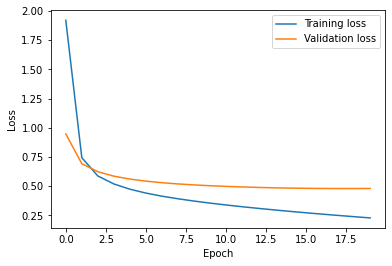

In [38]:
import matplotlib.pyplot as plt
total_epoch = 20

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
model = Model_MLP().to(device)   
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

train_loss = np.zeros(total_epoch)
valid_loss = np.zeros(total_epoch)

for epoch in range(total_epoch):
    print("Epoch {}/{}".format(epoch+1, total_epoch))
    model.train()              
    train_loss_array = []    
    for i, _data in enumerate(train_loader):
        _train_X, _train_Y = _data[0].to(device),_data[1].to(device)
        _train_Y = _train_Y.type(torch.LongTensor).to(device)
        optimizer.zero_grad()            
        pred_Y = model(_train_X) 

        loss = criterion(pred_Y, _train_Y) 
        loss.backward()             
        optimizer.step()              
        train_loss_array.append(loss.item())

    model.eval()                
    valid_loss_array = []
    hidden_valid = None
    for _valid_X, _valid_Y in valid_loader:
        _valid_X, _valid_Y = _valid_X.to(device), _valid_Y.to(device)
        _valid_Y = _valid_Y.type(torch.LongTensor).to(device)
        pred_Y = model(_valid_X)
        loss = criterion(pred_Y, _valid_Y) 
        valid_loss_array.append(loss.item())

    train_loss[epoch] = np.mean(train_loss_array)
    valid_loss[epoch] = np.mean(valid_loss_array)
    print("The train loss is {:.6f}. \n".format(train_loss[epoch]) + "The valid loss is {:.6f}.".format(valid_loss[epoch]))

plt.figure()
plt.plot(train_loss, label='Training loss')
plt.plot(valid_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [51]:
test_x = test_feature
test_y = test_target

In [52]:
test_x = torch.from_numpy(test_x).float()
test_set = TensorDataset(test_x)
test_loader = DataLoader(test_set, batch_size=1)
result = torch.Tensor().to(device)

model.eval()
for _data in test_loader:
    data_X = _data[0].to(device)
    pred_X = model(data_X)
    cur_pred = torch.squeeze(pred_X, dim=0)
    result = torch.cat((result, cur_pred), dim=0)

result

tensor([ -2.3647,  -2.2926,  -3.8962,  ..., -17.2494,  -4.2858,  -4.4941],
       device='cuda:0', grad_fn=<CatBackward0>)